<a href="https://colab.research.google.com/github/sdikici/Demand_Forecasting_Prophet_DeepAR/blob/main/LSTM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sercandikici/merged-dataset-electricty-weather-for-modelling
! unzip merged-dataset-electricty-weather-for-modelling.zip

Dataset URL: https://www.kaggle.com/datasets/sercandikici/merged-dataset-electricty-weather-for-modelling
License(s): unknown
100% 104k/104k [00:00<00:00, 390kB/s]
100% 104k/104k [00:00<00:00, 390kB/s]
Archive:  merged-dataset-electricty-weather-for-modelling.zip
  inflating: merged_data.csv         


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''Calculate and return the Mean Absolute Percentage Error (MAPE) between actual values (y_true) and predicted values (y_pred).'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def root_mean_squared_error(y_true, y_pred):
    '''Calculate and return the Root Mean Squared Error (RMSE) between actual values (y_true) and predicted values (y_pred).'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_true, y_pred):
    '''Calculate and return the coefficient of determination (R-squared) value showing the proportion of variance in the dependent variable predictable from the independent variable.'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [ ]:
'''
Read the CSV file 'merged_data.csv' into a DataFrame and assign it to df_merged.
Convert the 'settlement_date' column to datetime format.
'''
df_merged = pd.read_csv("merged_data.csv")
df_merged['settlement_date'] = pd.to_datetime(df_merged['settlement_date'])
df_merged

,settlement_date,tsd,is_holiday,temp
0,2021-01-01 00:00:00,28552.00,1.0,1.55
1,2021-01-01 02:00:00,26579.75,1.0,1.60
2,2021-01-01 04:00:00,25236.00,1.0,0.55
3,2021-01-01 06:00:00,25792.25,1.0,-0.35
4,2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...,...
13136,2023-12-31 16:00:00,34006.00,0.0,7.60
13137,2023-12-31 18:00:00,32273.00,0.0,8.20
13138,2023-12-31 20:00:00,27456.50,0.0,8.45
13139,2023-12-31 22:00:00,24139.25,0.0,8.35


In [ ]:
'''
Create a new DataFrame df_model_1 by selecting the columns 'tsd' and 'settlement_date' from df_merged.
Set the index of df_model_1 to the 'settlement_date' column.
'''

df_model_1 = df_merged[["tsd","settlement_date"]]
df_model_1= df_model_1.set_index("settlement_date")
df_model_1

,tsd
settlement_date,
2021-01-01 00:00:00,28552.00
2021-01-01 02:00:00,26579.75
2021-01-01 04:00:00,25236.00
2021-01-01 06:00:00,25792.25
2021-01-01 08:00:00,28162.75
...,...
2023-12-31 16:00:00,34006.00
2023-12-31 18:00:00,32273.00
2023-12-31 20:00:00,27456.50


In [ ]:
'''
Define the variable split_from as 90 multiplied by 12, indicating a train-test split of 90 days.
Split the DataFrame df_model_1 into train_data and test_data using the calculated split_from value.
'''

split_from = 90*12 #train test split is from 90days
train_data = df_model_1[:-split_from]
test_data = df_model_1[-split_from:]


In [ ]:
'''
Instantiate a MinMaxScaler object named scaler with a feature range between 0 and 1.
Scale the train_data using the fit_transform method of the scaler object and assign the result to train_scaled.
Scale the test_data using the transform method of the scaler object and assign the result to test_scaled.
'''

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
'''
Set parameters for LSTM model
Set the frequency of the time series data to "2H" (2 hours).
Define the number of days to predict.
Calculate the prediction length by multiplying the days to predict.
Set the context length equal to the prediction length.
Define the number of epochs for training the model as 12.
Set the batch size for training as 64.
Define the size of the cell (hidden state) in the recurrent neural network as 256.
'''
freq = "2H"
days_to_predict = 7  # days
prediction_length = days_to_predict*12  # Based on how many time steps ahead you want to predict
context_length = prediction_length
epochs = 12
batch_size=64
cell_size=256

In [ ]:
def create_dataset(data, look_back, prediction_length):

'''
This function prepares the input-output pairs for training an LSTM model.
It takes the input time series data, a parameter specifying the number of timesteps to look back (look_back), and the length of the prediction (prediction_length).
It creates sequences of input-output pairs from the data, where each input sequence contains look_back timesteps and each output sequence contains prediction_length timesteps.
These input-output pairs are used to train the LSTM model for time series forecasting.
'''
    X, Y = [], []
    for i in range(len(data) - look_back - prediction_length + 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back:i + look_back + prediction_length, 0])
    return np.array(X), np.array(Y).reshape(-1, prediction_length)

In [ ]:
'''
Prepare training and testing datasets:
- Create input-output pairs for training and testing datasets using the create_dataset function defined earlier.
- Reshape the input data to be in the format [samples, time steps, features] expected by the LSTM model. Here, features is 1 because we are using univariate time series data.
'''

X_train, y_train = create_dataset(train_scaled, context_length, prediction_length)
X_test, y_test = create_dataset(test_scaled, context_length, prediction_length)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
'''
Define the LSTM model architecture:
- Create a Sequential model.
- Add an LSTM layer with 'cell_size' number of units as the first hidden layer.
- Add a Dropout layer to prevent overfitting.
- Add a Dense layer with 'prediction_length' units as the output layer.
- Compile the model using the Adam optimizer and mean squared error loss function.
- Set up early stopping callback to monitor validation loss and stop training if no improvement is seen after 5 epochs.
'''

model_1 = Sequential()
model_1.add(LSTM(cell_size,
                 #return_sequences=True,
                 input_shape=(context_length, 1)))
model_1.add(Dropout(0.5))
#model_1.add(LSTM(int(cell_size/2)))
#model_1.add(Dropout(0.5))
model_1.add(Dense(prediction_length))  # Output layer has 'prediction_length' units
model_1.compile(optimizer='adam', loss='mean_squared_error')
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
'''
Train the LSTM model:
- Fit the model to the training data.
- Set the number of epochs to train ('epochs').
- Set the batch size for training ('batch_size').
- Specify verbose=1 to display training progress.
'''
model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/12
149/149 [==============================] - 23s 149ms/step - loss: 0.0514 - val_loss: 0.0174
Epoch 2/12
149/149 [==============================] - 22s 148ms/step - loss: 0.0308 - val_loss: 0.0157
Epoch 3/12
149/149 [==============================] - 22s 150ms/step - loss: 0.0231 - val_loss: 0.0156
Epoch 4/12
149/149 [==============================] - 22s 149ms/step - loss: 0.0177 - val_loss: 0.0106
Epoch 5/12
149/149 [==============================] - 22s 148ms/step - loss: 0.0160 - val_loss: 0.0115
Epoch 6/12
149/149 [==============================] - 22s 147ms/step - loss: 0.0143 - val_loss: 0.0107
Epoch 7/12
149/149 [==============================] - 22s 147ms/step - loss: 0.0135 - val_loss: 0.0094
Epoch 8/12
149/149 [==============================] - 22s 148ms/step - loss: 0.0130 - val_loss: 0.0090
Epoch 9/12
149/149 [==============================] - 22s 147ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 10/12
149/149 [==============================] - 22s 148ms/step - l

In [ ]:
'''
Generate predictions using the trained LSTM model:
- Use the trained model_1 to predict the output for the first sequence in the test data.
- Store the predictions in the variable 'predictions'.
'''
predictions = model_1.predict(X_test[:1])

1/1 [==============================] - 0s 298ms/step


In [ ]:
'''
Reverse scale the predicted and actual values to their original scale.
'''

predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test[:1].reshape(-1, 1))

In [ ]:
'''
Create DataFrames for the predicted and actual values:
- Use the 'predictions_inverse' array to create a DataFrame named 'forecast_df' with the predicted values. Set the index of this DataFrame to 'date_range'.
- Similarly, create a DataFrame named 'test_df' for the actual values using the 'y_test_inverse' array and set its index to 'date_range'.
'''
start_index = test_data.index[0]
date_range = pd.date_range(start=start_index, periods=len(predictions_inverse), freq='2H')
forecast_df = pd.DataFrame(predictions_inverse, index=date_range, columns=['Predicted'])
test_df = pd.DataFrame(y_test_inverse, index=date_range, columns=['Actual'])

In [ ]:
'''
Calculate and print evaluation metrics for model_1
'''
mape_1 = mean_absolute_percentage_error(test_df["Actual"], forecast_df["Predicted"])
rmse_1 = root_mean_squared_error(test_df["Actual"], forecast_df["Predicted"])
rsquared_1 = r_squared(test_df["Actual"], forecast_df["Predicted"])
print(f"MAPE without regressors: {round(mape_1,7)}")
print(f"RMSE without regressors: {round(rmse_1,7)}")
print(f"R-squared without regressors: {round(rsquared_1,7)}")

MAPE without regressors: 0.091312
RMSE without regressors: 2866.5448825
R-squared without regressors: 0.5919214


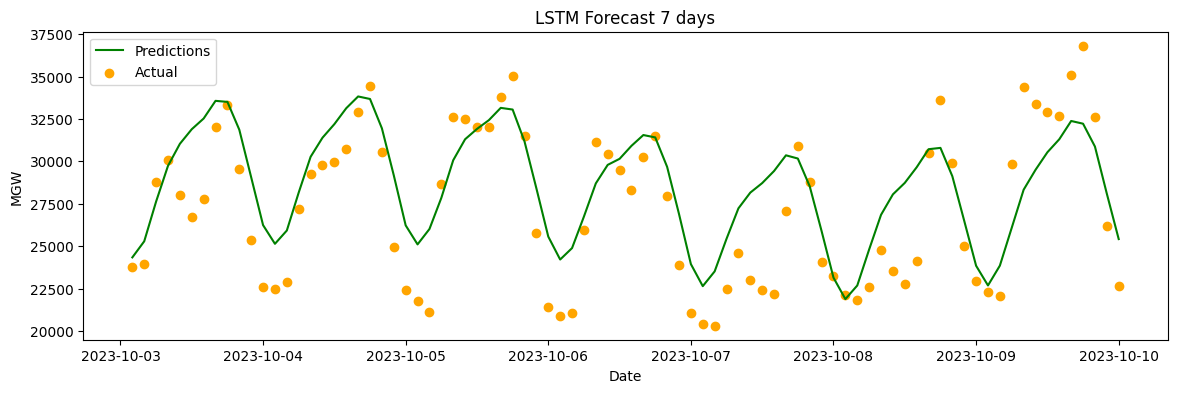

In [ ]:
def forecast_plot(predictions,y_test, days):
'''
Functiobn for plotting the forecasted and actual values:
- Plot the predicted values with a green line and label "Predictions".
- Scatter plot the actual values with orange color and label "Actual".
- Set the title of the plot as "LSTM Forecast {days} days", where {days} is the number of days to predict.
- Label the x-axis as "Date" and the y-axis as "MGW".
- Display a legend to differentiate between predicted and actual values.
- Show the plot.
'''
  plt.figure(figsize=(14, 4))
  plt.plot(predictions.index, predictions["Predicted"], label='Predictions',color="green")
  plt.scatter(y_test.index, y_test["Actual"], label='Actual',color="orange")
  plt.title(f'LSTM Forecast {days} days')
  plt.xlabel('Date')
  plt.ylabel('MGW')
  plt.legend()
  plt.show()

forecast_plot(forecast_df,test_df,days_to_predict)

model 2 with holiday

In [ ]:
'''
Create a DataFrame containing the target variable 'tsd' and the feature 'is_holiday':
- Select the columns "tsd", "settlement_date", and "is_holiday" from df_merged.
- Set the index of the DataFrame to "settlement_date".
Split the data into training and testing sets:
'''

df_model_2 = df_merged[["tsd","settlement_date","is_holiday"]]
df_model_2= df_model_2.set_index("settlement_date")

train_data_2 = df_model_2[:-split_from]
test_data_2 = df_model_2[-split_from:]

In [ ]:
'''
Scale the features using MinMaxScaler:
'''

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data_2)
test_scaled = scaler.transform(test_data_2)

In [ ]:
# Data preparation for LSTM
def create_dataset(data, look_back, prediction_length):
'''
Define a function to create datasets suitable for LSTM training:
- The function takes 'data' (scaled features), 'look_back' (number of time steps to look back), and 'prediction_length' (number of time steps to predict) as input.
- Initialize empty lists X and Y to store input-output pairs.
- Loop through the data to create input-output pairs:
  - For each time step 'i', create an input sequence of length 'look_back' containing all features.
  - Create an output sequence of length 'prediction_length' containing only the 'tsd' values.
- Convert lists X and Y into numpy arrays and reshape Y to have the appropriate shape.
- Return the input sequences X and output sequences Y.
'''
    X, Y = [], []
    for i in range(len(data) - look_back - prediction_length + 1):
        # X includes all features (here tsd and is_holiday)
        X.append(data[i:(i + look_back), :])  # Assuming multiple features including 'tsd' and 'is_holiday'
        # Y includes only the 'tsd' values which we are predicting
        Y.append(data[i + look_back:i + look_back + prediction_length, 0])  # '0' assuming 'tsd' is at position 0
    return np.array(X), np.array(Y).reshape(-1, prediction_length)


In [ ]:
'''
Create datasets for LSTM training using the defined function:
- Call the 'create_dataset' function with 'train_scaled', 'context_length', and 'prediction_length' to create training input-output pairs.
- Call the 'create_dataset' function with 'test_scaled', 'context_length', and 'prediction_length' to create testing input-output pairs.
- Store the input sequences and output sequences for training and testing in variables X_train, y_train, X_test, and y_test, respectively.
'''
X_train, y_train = create_dataset(train_scaled, context_length, prediction_length)
X_test, y_test = create_dataset(test_scaled, context_length, prediction_length)

In [ ]:
'''
Build the LSTM model_2 for electricity load forecasting including holiday regressors:
- Create a Sequential model instance.
- Add an LSTM layer with 'cell_size' units, specifying input shape as (context_length, number of features).
- Add a Dropout layer with dropout rate of 0.5 to prevent overfitting.
- Add a Dense layer with 'prediction_length' units for output.
- Compile the model using Adam optimizer and mean squared error loss.
- Define an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs.
'''

model_2 = Sequential()
model_2.add(LSTM(cell_size,
                 #return_sequences=True,
                 input_shape=(context_length,train_data_2.shape[1])))
model_2.add(Dropout(0.5))
#model_2.add(LSTM(int(cell_size/2)))
#model_2.add(Dropout(0.5))
model_2.add(Dense(prediction_length))
model_2.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
'''
Train the LSTM model_2:
- Fit the model to the training data (X_train, y_train).
- Specify the number of epochs, batch size, and validation split.
- Include the EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs.
'''

model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/12
149/149 [==============================] - 23s 148ms/step - loss: 0.0495 - val_loss: 0.0176
Epoch 2/12
149/149 [==============================] - 22s 145ms/step - loss: 0.0306 - val_loss: 0.0174
Epoch 3/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0211 - val_loss: 0.0110
Epoch 4/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0168 - val_loss: 0.0111
Epoch 5/12
149/149 [==============================] - 22s 149ms/step - loss: 0.0150 - val_loss: 0.0092
Epoch 6/12
149/149 [==============================] - 22s 147ms/step - loss: 0.0137 - val_loss: 0.0098
Epoch 7/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0132 - val_loss: 0.0096
Epoch 8/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0127 - val_loss: 0.0086
Epoch 9/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0120 - val_loss: 0.0090
Epoch 10/12
149/149 [==============================] - 22s 145ms/step - l

In [ ]:
'''
Make predictions using the trained LSTM model_2:
- Predict the first sequence of test data (X_test[:1]).
'''
predictions_2 = model_2.predict(X_test[:1])

1/1 [==============================] - 0s 297ms/step


In [ ]:
'''
Flatten the predictions array to prepare for inverse scaling and stacking with zeros array.
Create a zeros array with the same shape as the flattened predictions for the second feature columns.
Stack the flattened predictions and zeros array column-wise to ensure proper inverse scaling.
Inverse transform the combined array, selecting only the first column representing the 'tsd' feature.
Repeat the same process for the y_test data, ensuring proper reshaping and inverse scaling.
'''
predictions_flattened = predictions_2.flatten()
zeros_array = np.zeros_like(predictions_flattened)  # Create a zeros array that matches the shape of predictions_flattened

# Stack the arrays column-wise for inverse transformation
combined_array = np.column_stack((predictions_flattened, zeros_array))

# Inverse transform the predictions
predictions_inverse = scaler.inverse_transform(combined_array)[:, 0]

y_test_flattened = y_test[:1].flatten()
zeros_array_y_test = np.zeros_like(y_test_flattened)

# Stack and inverse transform the actual y_test data
combined_array_y_test = np.column_stack((y_test_flattened, zeros_array_y_test))
y_test_inverse = scaler.inverse_transform(combined_array_y_test)[:, 0]

In [ ]:
'''
Define the start index for the date range as the first index of the test data.
Create a date range with a frequency of 2 hours and a length matching the length of predictions_inverse.
Construct a DataFrame containing the predicted values with the date range as index and column name 'Predicted'.
Similarly, create a DataFrame for the actual values (y_test_inverse) with the same date range and column name 'Actual'.
'''
start_index = test_data_2.index[0]
date_range = pd.date_range(start=start_index, periods=len(predictions_inverse), freq='2H')
forecast_df_2 = pd.DataFrame(predictions_inverse, index=date_range, columns=['Predicted'])
test_df_2 = pd.DataFrame(y_test_inverse, index=date_range, columns=['Actual'])

In [ ]:
'''
Calculate Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), and R-squared values for the LSTM model_2 with holidays included.
'''
mape_2 = mean_absolute_percentage_error(test_df_2["Actual"], forecast_df_2["Predicted"])
rmse_2 = root_mean_squared_error(test_df_2["Actual"], forecast_df_2["Predicted"])
rsquared_2 = r_squared(test_df_2["Actual"], forecast_df_2["Predicted"])
print(f"MAPE with holiday: {round(mape_2,7)}")
print(f"RMSE with holiday: {round(rmse_2,7)}")
print(f"R-squared with holiday: {round(rsquared_2,7)}")

MAPE with holiday: 0.0787709
RMSE with holiday: 2596.5121136
R-squared with holiday: 0.6651833


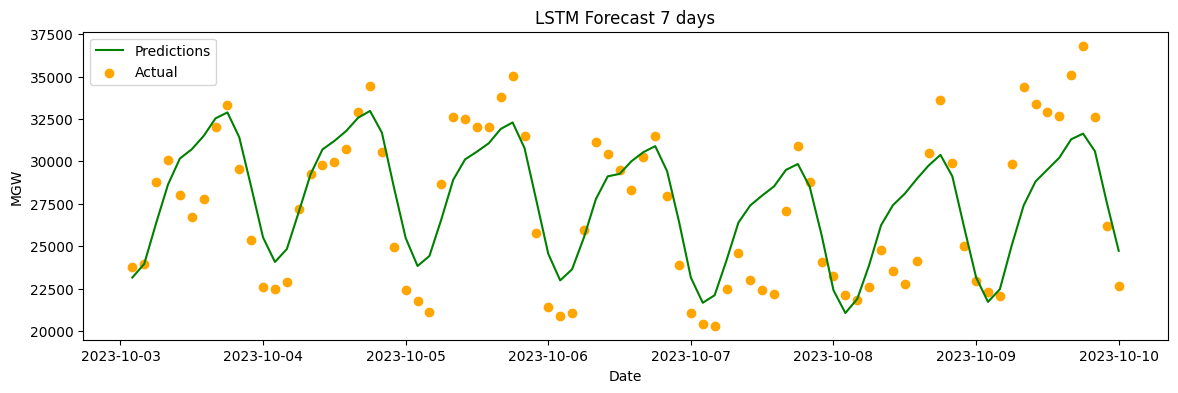

In [ ]:
'''
Generate a forecast plot for the LSTM model_2 with holidays included.
The plot will display the predicted and actual values for the specified number of days.
'''
forecast_plot(forecast_df_2,test_df_2,days_to_predict)

model 3 with holiday and temp

In [ ]:
'''
Prepare the data for the LSTM model_3 including both weather data and holiday indicators.
Split train and test datasets
'''

df_model_3 = df_merged[["tsd","settlement_date","is_holiday","temp"]]
df_model_3= df_model_3.set_index("settlement_date")

train_data_3 = df_model_3[:-split_from]
test_data_3 = df_model_3[-split_from:]

In [ ]:
'''
Scale the data using MinMaxScaler to ensure all features are within the range [0, 1].
'''
scaler_3 = MinMaxScaler(feature_range=(0, 1))
train_scaled_3 = scaler_3.fit_transform(train_data_3)
test_scaled_3 = scaler_3.transform(test_data_3)

In [ ]:
'''
Define a function create_dataset to prepare the data for LSTM training.
The function takes input data, look_back (context length), and prediction_length as parameters.
It iterates over the input data to create input-output pairs for the LSTM model.
It returns two arrays X and Y, where X contains input sequences with all features, and Y contains output sequences for 'tsd' only.
'''
def create_dataset(data, look_back, prediction_length):
    X, Y = [], []
    for i in range(len(data) - look_back - prediction_length + 1):
        X.append(data[i:(i + look_back), :])  # Include all features
        Y.append(data[i + look_back:i + look_back + prediction_length, 0])  # Only 'tsd' as output
    return np.array(X), np.array(Y).reshape(-1, prediction_length)

In [ ]:
'''
Prepare the training and testing data for LSTM training using the create_dataset function defined earlier.
Create input-output pairs for the LSTM model using the training and testing data.
Reshape the input data to match the input shape required by LSTM.
'''

X_train_3, y_train_3 = create_dataset(train_scaled_3, context_length, prediction_length)
X_test_3, y_test_3 = create_dataset(test_scaled_3, context_length, prediction_length)

# Reshape for LSTM
X_train_3 = X_train_3.reshape((X_train_3.shape[0], X_train_3.shape[1], train_data_3.shape[1]))
X_test_3 = X_test_3.reshape((X_test_3.shape[0], X_test_3.shape[1], train_data_3.shape[1]))

In [ ]:
'''
Create the LSTM model_3 for training includes holiday and temp.
Add an LSTM layer with the specified cell size and input shape.
Add a dropout layer to prevent overfitting.
Add a dense output layer with units equal to the prediction length.
Compile the model using the Adam optimizer and mean squared error loss.
Define early stopping to monitor validation loss and stop training if it does not improve for a certain number of epochs.
'''
model_3 = Sequential()
model_3.add(LSTM(cell_size,
                 #return_sequences=True,
                 input_shape=(context_length, train_data_3.shape[1])))
model_3.add(Dropout(0.5))
#model_3.add(LSTM(int(cell_size/2)))
#model_3.add(Dropout(0.5))
model_3.add(Dense(prediction_length))
model_3.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
'''
Train the LSTM model_3 using the training data.
'''
model_3.fit(X_train_3, y_train_3, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/12
149/149 [==============================] - 23s 149ms/step - loss: 0.0454 - val_loss: 0.0161
Epoch 2/12
149/149 [==============================] - 22s 145ms/step - loss: 0.0254 - val_loss: 0.0133
Epoch 3/12
149/149 [==============================] - 21s 144ms/step - loss: 0.0174 - val_loss: 0.0131
Epoch 4/12
149/149 [==============================] - 22s 145ms/step - loss: 0.0155 - val_loss: 0.0119
Epoch 5/12
149/149 [==============================] - 21s 144ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 6/12
149/149 [==============================] - 21s 144ms/step - loss: 0.0133 - val_loss: 0.0106
Epoch 7/12
149/149 [==============================] - 22s 146ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 8/12
149/149 [==============================] - 22s 145ms/step - loss: 0.0122 - val_loss: 0.0089
Epoch 9/12
149/149 [==============================] - 22s 145ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 10/12
149/149 [==============================] - 22s 145ms/step - l

In [ ]:
'''
Predict using the trained LSTM model_3 on the test data.
Flatten the predictions array to match the shape for inverse transformation.
Calculate the number of additional features (excluding the target variable).
Create a zeros array with the same shape as the additional features.
Combine the predictions with the zeros array for inverse transformation.
Inverse transform the predictions using the scaler.
Repeat the process for the flattened y_test data.
'''
predictions_3 = model_3.predict(X_test_3[:1])
predictions_3_flat = predictions_3.flatten()
num_features = train_data_3.shape[1] - 1

# Create a zeros array that has the correct shape
zeros_array = np.zeros((len(predictions_3_flat), num_features))

# Combine the predictions with the zeros array for inverse transformation
predictions_combined = np.c_[predictions_3_flat, zeros_array]

# Inverse transform the predictions
predictions_inverse_3 = scaler_3.inverse_transform(predictions_combined)[:, 0]

# The same process for y_test_3
y_test_3_flat = y_test_3[:1].flatten()  # Make sure this flattening matches the dimension expectation
zeros_array_y_test = np.zeros((len(y_test_3_flat), num_features))
y_test_combined = np.c_[y_test_3_flat, zeros_array_y_test]

# Inverse transform y_test
y_test_inverse_3 = scaler_3.inverse_transform(y_test_combined)[:, 0]

1/1 [==============================] - 0s 274ms/step


In [ ]:
'''
Define the start index for the forecast DataFrame based on the first index of the test data.
Create a date range for the forecast based on the length of the predictions, with a frequency of 2 hours.
Create a DataFrame for the forecast with the predicted values, using the date range as index.
Create a DataFrame for the actual values with the y_test_inverse_3 values and the same date range as index.
'''

start_index_3 = test_data_3.index[0]
date_range_3 = pd.date_range(start=start_index_3, periods=len(predictions_inverse_3), freq='2H')
forecast_df_3 = pd.DataFrame(predictions_inverse_3, index=date_range_3, columns=['Predicted'])
test_df_3 = pd.DataFrame(y_test_inverse_3, index=date_range_3, columns=['Actual'])

In [ ]:
'''
Calculate Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), and R-squared values for the LSTM model_3 with holidays and temp included.
'''
mape_3 = mean_absolute_percentage_error(test_df_3["Actual"], forecast_df_3["Predicted"])
rmse_3 = root_mean_squared_error(test_df_3["Actual"], forecast_df_3["Predicted"])
rsquared_3 = r_squared(test_df_3["Actual"], forecast_df_3["Predicted"])
print(f"MAPE with holiday and temp: {round(mape_3,7)}")
print(f"RMSE with holiday and temp: {round(rmse_3,7)}")
print(f"R-squared with holiday and temp: {round(rsquared_3,7)}")

MAPE with holiday and temp: 0.0709087
RMSE with holiday and temp: 2449.3693677
R-squared with holiday and temp: 0.7020558


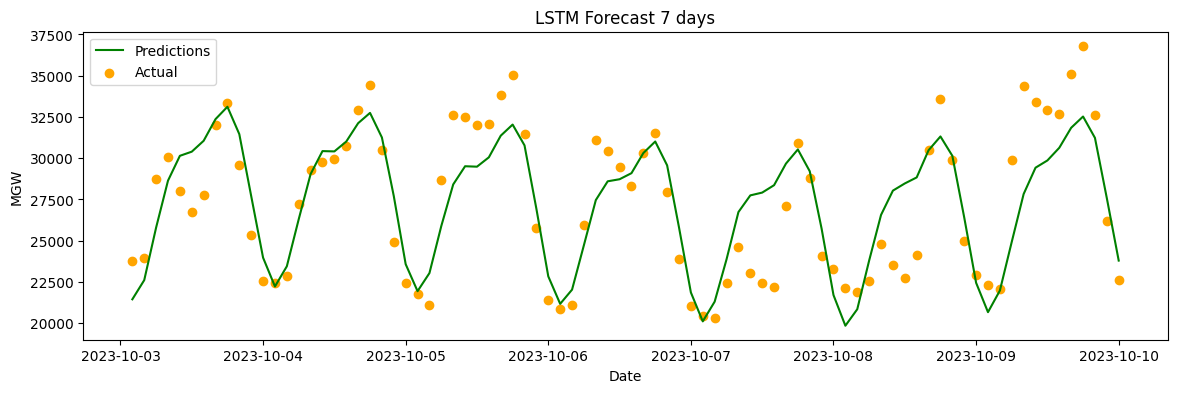

In [ ]:
'''
Generate a forecast plot for the LSTM model_3 with holidays and temp included.
The plot will display the predicted and actual values for the specified number of days.
'''
forecast_plot(forecast_df_3,test_df_3,days_to_predict)